In [ ]:
階層ベイズでやったがうまく推定できなかったもの

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pystan
import math
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [7]:
df=pd.read_csv("../input/q_data_x.csv")

In [8]:
df["TVwatch_day"]=df["TVwatch_day"]/10000
#df["gamesecond"]=(df["gamesecond"]/100).astype(int)
#スケール＋切り上げ
df["gamesecond"]=[math.ceil(i/10000) for i in df["gamesecond"]]

In [9]:
X=df[['cm_dummy','T','F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',"child_dummy"]]

In [10]:
tmp=df[['T','F1', 'F2', 'F3', 'M1', 'M2', 'M3']]
for n,i in enumerate(tmp.columns):
    tmp[i]*=(n+1)

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
DID=list(tmp.max(axis=1))

In [138]:
#階層ベイズで、負の二項分布としてとく
model="""
data {
  int N;
  int<lower=0> Y[N];
  //matrix[N,D] X;
  int DID[N];
  int CM[N];
  real TV[N];
  int CH[N];
  int D; //デモグラの種別数
}

parameters {
  real da0 ; //切片
  real db0 ; //cm接触の重み
  real dc0 ; //TV視聴の重み
  real dd0 ; //子供の重み
  real da[D];
  real db[D];
  real dc[D];
  real dd[D];
  real<lower=0> s_da ;
  real<lower=0> s_db ;
  real<lower=0> s_dc ;
  real<lower=0> s_dd ;
  real<lower=0> s_Y ;
  //real d1;
  //real d2;
  //real d3;
}

  

model {
  //real<lower=0> mu;
  //real<lower=0> s_Y;
  //mu ~ cauchy(0,5);
  s_da ~ cauchy(0,5);
  s_db ~ cauchy(0,5);
  s_dc ~ cauchy(0,5);
  s_dd ~ cauchy(0,5);
  s_Y ~ cauchy(0,5);
  da0 ~ cauchy(0,5);
  db0 ~ cauchy(0,5);
  dc0 ~ cauchy(0,5);
  dd0 ~ cauchy(0,5);
  //s_Y ~ uniform(0,1);
  
  for (d in 1:D) {
      da[d] ~ normal(da0 , s_da);
      db[d] ~ normal(db0 , s_db);
      dc[d] ~ normal(dc0 , s_dc);
      dd[d] ~ normal(dd0 , s_dd);
  }

  for (n in 1:N){
      //real mu = exp(da[DID[n]]+CM[n]*db[DID[n]]+TV[n]*dc[DID[n]]+CH[n]*dd[DID[n]]);
      real mu = exp(CM[n]*db[DID[n]]+TV[n]*dc[DID[n]]+CH[n]*dd[DID[n]]);
      //real mu = exp(CM[n]*db[DID[n]]+CH[n]*d3);
      //mu ~ cauchy(0,5);
      //real mu = da[DID[n]]+CM[n]*db[DID[n]];
      Y[n] ~ neg_binomial_2_log(mu, s_Y);
 }
}
"""

In [139]:
data={'N': df.shape[0],'Y':df["gamesecond"],'DID':DID,"CM":df["cm_dummy"],"TV":df["TVwatch_day"],"CH":df["child_dummy"],"D":7}

In [140]:
%time fit = pystan.stan(model_code=model, data=data, iter=1000, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_509844cb10e947532f4f7aa961db2bd5 NOW.


CPU times: user 2.74 s, sys: 666 ms, total: 3.41 s
Wall time: 21min 45s


In [141]:
fit

Inference for Stan model: anon_model_509844cb10e947532f4f7aa961db2bd5.
3 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
da0    11.52    7.82  41.84 -79.48   -2.2   6.48   25.4 145.34     29   1.13
db0   -14.39     6.0   36.7 -103.8  -9.85  -5.26  -3.59   0.81     37   1.08
dc0   -121.9   55.07 179.02 -826.2 -147.9 -48.62 -23.82 -18.69     11   1.23
dd0    -12.2    2.35  15.02 -47.36 -12.83  -7.95  -6.65  -0.06     41   1.08
da[1]  11.71    7.53  43.55  -84.7  -2.92  10.15  25.42 144.49     33   1.11
da[2]  10.32    7.77  46.49 -95.97  -3.49   9.51  25.82 132.51     36   1.08
da[3]  12.84    7.95  44.23 -81.45  -3.15  11.32  25.37 148.87     31   1.13
da[4]  10.55    7.38  45.36 -92.82  -4.02   9.85  25.79 132.29     38   1.08
da[5]  11.34    7.68  43.95 -82.33   -3.8   8.66  25.75 143.75     33   1.12
da[6]  12.52    8.22   44.2 -77.69  -2.82  

In [142]:
# サンプル列を抽出
la  = fit.extract(permuted=True)

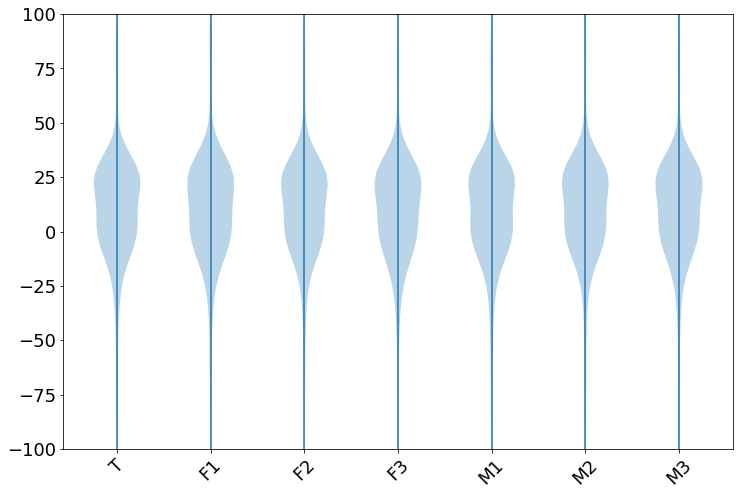

In [148]:
#ゲームプレイ有無への寄与度
plt.figure(figsize=(12,8))
plt.violinplot([la["da"][:,i] for i in range(7)])
plt.xticks(list(range(1,len(tmp.columns)+1)), tmp.columns)
plt.ylim(-100, 100)
plt.xticks(rotation=45)
plt.tick_params(labelsize=18)
plt.show()

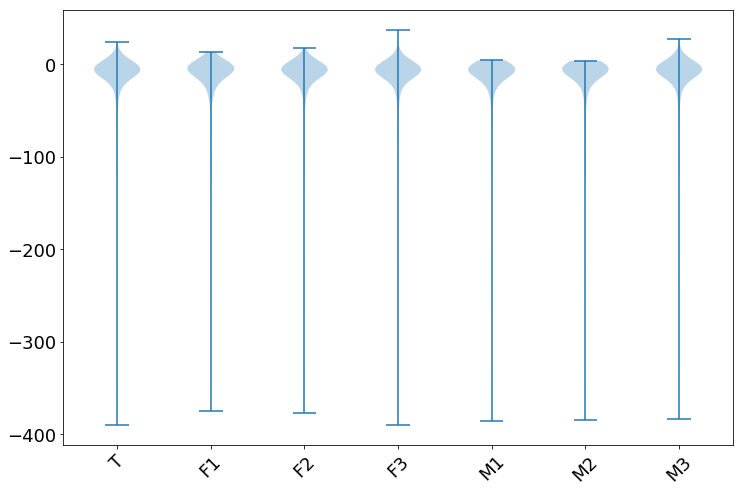

In [144]:
#ゲームプレイ有無への寄与度
plt.figure(figsize=(12,8))
plt.violinplot([la["db"][:,i] for i in range(7)])
plt.xticks(list(range(1,len(tmp.columns)+1)), tmp.columns)
plt.xticks(rotation=45)
plt.tick_params(labelsize=18)
plt.show()

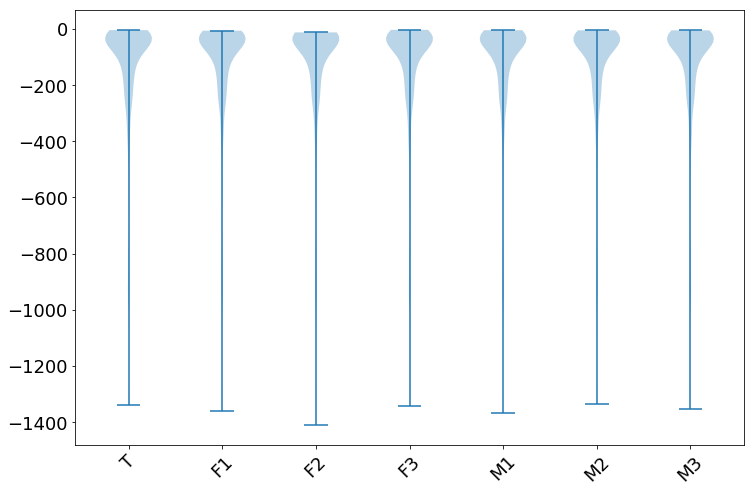

In [145]:
#ゲームプレイ有無への寄与度
plt.figure(figsize=(12,8))
plt.violinplot([la["dc"][:,i] for i in range(7)])
plt.xticks(list(range(1,len(tmp.columns)+1)), tmp.columns)
plt.xticks(rotation=45)
plt.tick_params(labelsize=18)
plt.show()

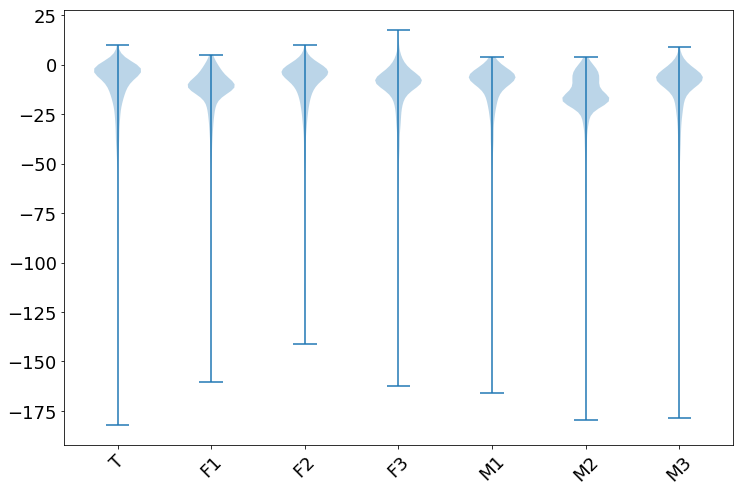

In [146]:
#ゲームプレイ有無への寄与度
plt.figure(figsize=(12,8))
plt.violinplot([la["dd"][:,i] for i in range(7)])
plt.xticks(list(range(1,len(tmp.columns)+1)), tmp.columns)
plt.xticks(rotation=45)
plt.tick_params(labelsize=18)
plt.show()

In [88]:
#GLMでやる
import statsmodels.api as sm
X2=df[['cm_dummy','T','F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',"child_dummy"]]
Y2=df["gamesecond"]
#data.exog = sm.add_constant(data.exog)
#formula_nv="gamesecond ~ log 
gamma_model = sm.GLM(Y2,X2 , family=sm.families.NegativeBinomial())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             gamesecond   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9990
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7033.3
Date:                Sat, 16 Feb 2019   Deviance:                       10807.
Time:                        10:01:47   Pearson chi2:                 6.84e+04
No. Iterations:                     9   Covariance Type:             nonrobust
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
cm_dummy       -0.0025      0.046     -0.054      0.957      -0.093       0.088
T              -0.4210      0.138     -3.051     